<a href="https://colab.research.google.com/github/Francis-Njuguna/30_Days_Of_Python/blob/main/weather_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Where to find weather data:

*   **National Oceanic and Atmospheric Administration (NOAA)**: NOAA provides extensive historical weather data, including daily summaries, hourly observations, and more. You can often access this through their climate data online portal or specific APIs.
*   **OpenWeatherMap API**: This provides current and historical weather data for various locations. You might need an API key for extensive historical data.
*   **Kaggle**: Many datasets, including weather data from various regions and timeframes, are available on Kaggle. Searching for 'weather dataset' will give you many options.
*   **Government meteorological services**: Many countries have their own meteorological agencies that provide public access to historical weather data.

Once you have downloaded a dataset (often in CSV format), you can load it into your notebook. The first step will typically be to load this data into a pandas DataFrame.

### General Steps to build a simple weather prediction model:

1.  **Load Data**: Import your historical weather data.
2.  **Explore and Clean Data**: Understand its structure, handle missing values, and check for anomalies.
3.  **Feature Engineering**: Create new features that might be useful for prediction (e.g., day of the week, month, rolling averages of temperature).
4.  **Define Target Variable**: Decide what you want to predict (e.g., tomorrow's maximum temperature, rainfall).
5.  **Split Data**: Divide your data into training and testing sets.
6.  **Choose and Train Model**: Select a suitable machine learning model (e.g., Linear Regression, Random Forest, ARIMA for time series) and train it on your training data.
7.  **Evaluate Model**: Assess your model's performance on the test set using appropriate metrics (e.g., Mean Absolute Error, R-squared).

Here's a basic structure to get you started. Please replace `your_weather_data.csv` with the path to your actual data file and adjust the column names as per your dataset.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# --- Step 1: Load Data ---
# Replace 'your_weather_data.csv' with the actual path to your weather dataset.
# Ensure your CSV file has columns like 'Date', 'Max_Temp', 'Min_Temp', 'Humidity', 'Precipitation', etc.
try:
    df = pd.read_csv('/content/seattle-weather.csv') # <--- CHANGE 'your_weather_data.csv' to your actual file name here
    print("Data loaded successfully. Here are the first 5 rows:")
    display(df.head())
except FileNotFoundError:
    print("Error: 'your_weather_data.csv' not found. Please upload your data file or provide the correct path.")
    print("You can upload a file by clicking the folder icon on the left panel, then the 'upload to session storage' icon.")
    df = None # Set df to None to avoid further errors if file not found

Data loaded successfully. Here are the first 5 rows:


,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [5]:
if df is not None:
    # --- Step 2 & 3: Explore, Clean and Feature Engineer Data ---
    # Convert 'Date' column to datetime objects
    if 'date' in df.columns: # Changed 'Date' to 'date' to match the dataframe
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')

        # Example: Create features like day of week, month, year
        df['DayOfWeek'] = df['date'].dt.dayofweek
        df['Month'] = df['date'].dt.month
        df['Year'] = df['date'].dt.year

        # Example: Lagged features (e.g., yesterday's max temperature to predict today's)
        # Make sure your data is sorted by date and location if applicable before creating lagged features
        # For simplicity, we'll assume a single location for now.
        if 'temp_max' in df.columns: # Changed 'Max_Temp' to 'temp_max'
            df['Prev_Day_temp_max'] = df['temp_max'].shift(1) # Changed 'Max_Temp' to 'temp_max'

    # Drop rows with NaN values created by shifting or initial missing values
    df = df.dropna()

    print("\nData after basic preprocessing and feature engineering:")
    display(df.head())
    print("\nDataFrame Info:")
    df.info()


Data after basic preprocessing and feature engineering:


,date,precipitation,temp_max,temp_min,wind,weather,DayOfWeek,Month,Year,Prev_Day_temp_max
1,2012-01-02,10.9,10.6,2.8,4.5,rain,0,1,2012,12.8
2,2012-01-03,0.8,11.7,7.2,2.3,rain,1,1,2012,10.6
3,2012-01-04,20.3,12.2,5.6,4.7,rain,2,1,2012,11.7
4,2012-01-05,1.3,8.9,2.8,6.1,rain,3,1,2012,12.2
5,2012-01-06,2.5,4.4,2.2,2.2,rain,4,1,2012,8.9



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1460 non-null   datetime64[ns]
 1   precipitation      1460 non-null   float64       
 2   temp_max           1460 non-null   float64       
 3   temp_min           1460 non-null   float64       
 4   wind               1460 non-null   float64       
 5   weather            1460 non-null   object        
 6   DayOfWeek          1460 non-null   int32         
 7   Month              1460 non-null   int32         
 8   Year               1460 non-null   int32         
 9   Prev_Day_temp_max  1460 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int32(3), object(1)
memory usage: 108.4+ KB


In [6]:
if df is not None and not df.empty:
    # --- Step 4: Define Target Variable and Features ---
    # Let's assume we want to predict 'temp_max' (Maximum Temperature)
    # Adjust 'target_column' and 'feature_columns' based on your dataset.
    target_column = 'temp_max'

    # Example features. Choose relevant columns that predict your target.
    # Ensure these columns exist in your DataFrame.
    feature_columns = ['temp_min', 'precipitation', 'wind', 'Prev_Day_temp_max', 'DayOfWeek', 'Month'] # Adjusted to match available columns

    # Filter to only include columns that actually exist in the DataFrame
    feature_columns = [col for col in feature_columns if col in df.columns and col != target_column]

    if target_column not in df.columns or not feature_columns:
        print(f"Error: Target column '{target_column}' or specified feature columns not found in the data after preprocessing. Please adjust.")
    else:
        X = df[feature_columns]
        y = df[target_column]

        # --- Step 5: Split Data ---
        # Using a time-series split is more appropriate for weather data,
        # but for a simple model, we'll use a random train-test split for now.
        # For better time-series models, consider TimeSeriesSplit or manual split.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        print(f"\nTraining data shape: {X_train.shape}")
        print(f"Testing data shape: {X_test.shape}")

        # --- Step 6: Choose and Train Model ---
        # Using a simple Linear Regression model
        model = LinearRegression()
        model.fit(X_train, y_train)

        print("\nModel trained successfully!")

        # --- Step 7: Evaluate Model ---
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"\nModel Evaluation on Test Data:")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        print(f"R-squared (R2): {r2:.2f}")

        # Display some predictions vs actuals
        results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
        print("\nSample of Actual vs Predicted values:")
        display(results.head())
else:
    print("Cannot proceed with model building as the DataFrame is empty or not loaded.")


Training data shape: (1168, 6)
Testing data shape: (292, 6)

Model trained successfully!

Model Evaluation on Test Data:
Mean Absolute Error (MAE): 2.08
R-squared (R2): 0.88

Sample of Actual vs Predicted values:


,Actual,Predicted
893,21.7,22.978275
1106,9.4,11.385764
414,7.8,10.545875
523,21.7,25.527171
1037,13.9,14.724649


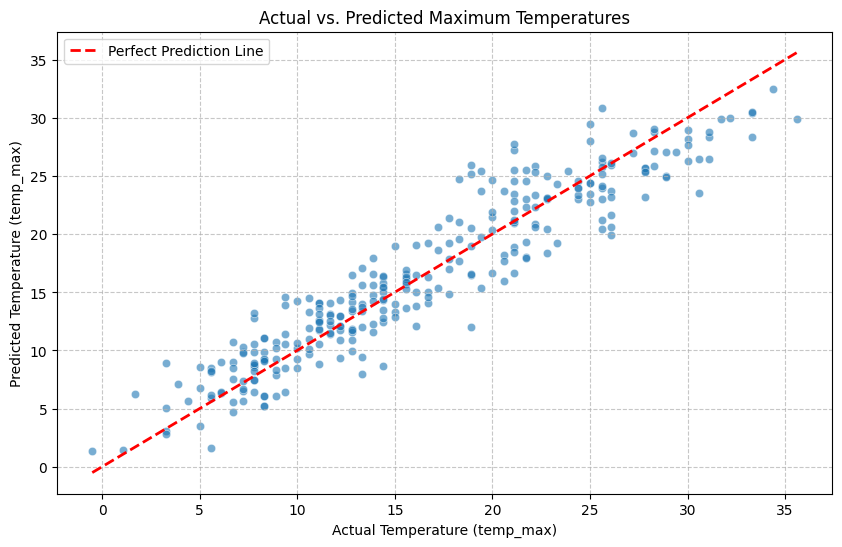

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the 'results' DataFrame exists from the previous steps
if 'results' in locals():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Actual', y='Predicted', data=results, alpha=0.6)
    plt.plot([results['Actual'].min(), results['Actual'].max()],
             [results['Actual'].min(), results['Actual'].max()],
             'r--', lw=2, label='Perfect Prediction Line')
    plt.xlabel('Actual Temperature (temp_max)')
    plt.ylabel('Predicted Temperature (temp_max)')
    plt.title('Actual vs. Predicted Maximum Temperatures')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
else:
    print("The 'results' DataFrame was not found. Please ensure the model training and evaluation cell (cell 6097e7b6) has been run successfully.")

In [7]:
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Mean Absolute Error (MAE): 2.08
R-squared (R2): 0.88
